## Demographic plots


This notebook loads in the demographic features for all participants 

It produces plots for relationships of interest from the grid analysis

In [4]:

# Import packages
import pool.paths as paths
import os
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import pool.hdf5_io as hio
import scipy.stats as st
import ptitprince as pt
import seaborn as sns
import scipy.stats as stats
import scipy.special as special
from matplotlib.patches import Patch
from scipy.ndimage import gaussian_filter


In [12]:
demographics_filename = os.path.join(paths.data_dir,'demographics_qc.csv')

In [13]:
demographics=pd.read_csv(demographics_filename)


In [14]:
ages=np.hstack([demographics['Age of onset'],
           demographics['Age at preoperative'],
           demographics['Duration']])

label_ints = np.ndarray.flatten(np.hstack((np.ones_like(demographics['Age of onset']),
                                           2*np.ones_like(demographics['Age at preoperative']),
                                          3*np.ones_like(demographics['Duration'])))).astype(int)


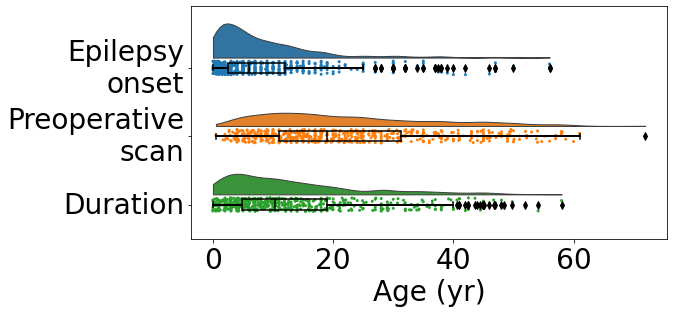

In [15]:
fig1, ax1 = plt.subplots(figsize=(10,5))
plt.rcParams.update({'font.size': 28})

pt.half_violinplot(x=ages,y=label_ints, bw=.15,  linewidth=1,cut=0.,\
                   scale="area", width=1, inner=None,orient="h")
sns.boxplot(x=ages,y=label_ints, color="black",orient="h",width=.15,zorder=10,\
               showcaps=True,boxprops={'facecolor':'none', "zorder":10},\
                showfliers=True,whiskerprops={'linewidth':2, "zorder":10},saturation=1)
sns.stripplot(x=ages,y=label_ints, edgecolor="white",size=3,orient="h",\
                  jitter=1,zorder=0)
ax1.set_ylim([2.5,-0.9])
#ax1.set_title('Onset of epilepsy and preoperative scan')
ax1.set_yticklabels(['Epilepsy\nonset','Preoperative\nscan','Duration'],
                    va="center",ha = 'right')
ticklabels = ax1.get_yticklabels()
    # set the alignment for outer ticklabels

ax1.set_xlabel('Age (yr)')

fig1.tight_layout()

fig1.savefig(os.path.join(paths.fig_dir,'ages_of_onset.pdf'), transparent=True)


In [16]:
data = demographics[['Lesion area','Surgery','Age of onset']].dropna()

def norm_transform(df,variables,transform='log',return_lambdas=False):
    """transform continuous data"""
    lambdas={}
    for k,variable in enumerate(variables):
        if transform =='log':
            df[variable]=np.log(np.array(df[variable])+1)
        elif transform =='boxcox':
            if np.nanmin(df[variable]) <0:
                df[variable][~df[variable].isnull()]=df[variable][~df[variable].isnull()]-np.nanmin(df[variable])+0.1
            lambdas[variable] = stats.boxcox(np.array(df[variable].dropna())+0.1)[1]
            df[variable][~df[variable].isnull()]=stats.boxcox(np.array(df[variable].dropna())+0.1)[0]
    if return_lambdas:
        return df, lambdas
    return df

features_to_normalise=['Age of onset','Lesion area'] #+imaging_variables
data,lambdas=norm_transform(data,features_to_normalise,
                  transform='boxcox',return_lambdas=True)

t1,p1=stats.ttest_ind(data['Lesion area'][data['Surgery']==1],
     data['Lesion area'][data['Surgery']==0])
t2,p2=stats.ttest_ind(data['Age of onset'][data['Surgery']==1],
     data['Age of onset'][data['Surgery']==0])
R,p3=stats.spearmanr(data['Age of onset'],data['Lesion area'])
xticks=np.linspace(np.percentile(data['Lesion area'],0),np.percentile(data['Lesion area'],99),8)
xticklabels = np.round((special.inv_boxcox(xticks, lambdas['Lesion area'])-0.1)*100,1)
yticks=np.linspace(np.percentile(data['Age of onset'],1),np.percentile(data['Age of onset'],99),8)
yticklabels = np.round(-0.1+special.inv_boxcox(yticks, lambdas['Age of onset']),1)


/home/kwagstyl/anaconda2/envs/meld_classifier/lib/python3.6/site-packages/seaborn/distributions.py:1649: FutureWarning: The `vertical` parameter is deprecated and will be removed in a future version. Assign the data to the `y` variable instead.
  warnings.warn(msg, FutureWarning)
/home/kwagstyl/anaconda2/envs/meld_classifier/lib/python3.6/site-packages/seaborn/distributions.py:1649: FutureWarning: The `vertical` parameter is deprecated and will be removed in a future version. Assign the data to the `y` variable instead.
  warnings.warn(msg, FutureWarning)


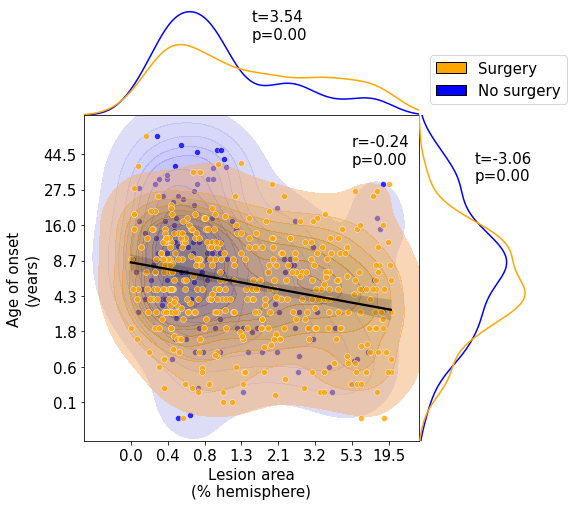

In [17]:
import warnings
# warnings.simplefilter(action='ignore', category=FutureWarning)
# warnings.simplefilter(action='ignore', category=UserWarning)

fig,axes=plt.subplots(2,2,figsize=(8,8),
                      gridspec_kw={'width_ratios': [3, 1],'height_ratios': [1, 3],},sharex='col', sharey='row',
                     )
plt.subplots_adjust(hspace=0.0,wspace=0.0)

#fig = plt.figure(figsize=(8,8))


sns.kdeplot(x=data['Lesion area'][data['Surgery']!=1],
            y=data['Age of onset'][data['Surgery']!=1],
            shade=True, thresh=0.05,alpha=0.5,
            color='blue',ax=axes[1,0])
sns.scatterplot(x=data['Lesion area'][data['Surgery']!=1],
                y=data['Age of onset'][data['Surgery']!=1],alpha=0.8,
            color='blue',ax=axes[1,0])
sns.kdeplot(x=data['Lesion area'][data['Surgery']==1],
            y=data['Age of onset'][data['Surgery']==1],
            shade=True,thresh=0.05,alpha=0.5,
           color='orange',ax=axes[1,0])
sns.scatterplot(x=data['Lesion area'][data['Surgery']==1],
                y=data['Age of onset'][data['Surgery']==1],alpha=0.8,
           color='orange',ax=axes[1,0])
sns.regplot(x=data['Lesion area'],
            y=data['Age of onset'],scatter=False,color='black',ax=axes[1,0])
sns.kdeplot(data['Lesion area'][data['Surgery']==0],
            color='blue',ax=axes[0,0],legend=False,bw_method=0.3)
sns.kdeplot(data['Lesion area'][data['Surgery']==1],
            color='orange',ax=axes[0,0],legend=False,bw_method=0.3)

sns.kdeplot(data['Age of onset'][data['Surgery']==0],
            color='blue',ax=axes[1,1],legend=False,vertical=True,bw_method=0.3)

sns.kdeplot(data['Age of onset'][data['Surgery']==1],
            color='orange',ax=axes[1,1],legend=False,vertical=True,bw_method=0.3)
axes[0,0].text(0.5,0.7,'t={:.2f}\np={:.2f}'.format(t1,p1),
               transform=axes[0,0].transAxes,fontsize=15)
axes[1,1].axis('off')
axes[0,1].axis('off')
axes[0,0].axis('off')
axes[1,0].set_xticks(xticks) #,xticklabels)
axes[1,0].set_xticklabels(xticklabels,fontsize=15)
axes[1,0].set_xlim([-8800,800])
axes[1,0].set_yticks(yticks) #,xticklabels)
axes[1,1].text(0.5,0.8,'t={:.2f}\np={:.2f}'.format(t2,p2),transform=axes[1,1].transAxes,fontsize=15)

axes[1,0].text(0.8,0.85,'r={:.2f}\np={:.2f}'.format(R,p3),transform=axes[1,0].transAxes,fontsize=15)
axes[1,0].set_yticklabels(yticklabels,fontsize=15)
axes[1,0].set_ylim([-2.5,7])
axes[1,0].set_ylabel('Age of onset\n(years)',fontsize=15)
axes[1,0].set_xlabel('Lesion area\n(% hemisphere)',fontsize=15)

legend_elements = [
                   Patch(facecolor='orange', edgecolor='k',
                         label='Surgery'),
        Patch(facecolor='blue', edgecolor='k',
                         label='No surgery')]
axes[0,1].legend(handles=legend_elements, loc=[0.1,0.1],prop={'size': 15})
fig.savefig(os.path.join(paths.fig_dir,'age_size_surgery.pdf'), transparent=True)

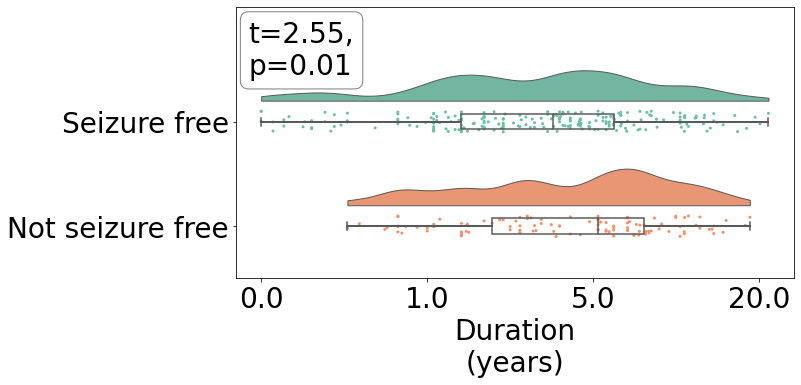

In [18]:
plt.figure(figsize=(10,5))
data=demographics[['Duration','Age at preoperative','Seizure free']].dropna()
features_to_normalise=['Duration','Age at preoperative']
data,lambdas=norm_transform(data,features_to_normalise,
                  transform='log',return_lambdas=True)

pt.RainCloud(x="Seizure free",y='Duration',data=data,orient='h',order=[1,0])
xticks = np.linspace(0,4,4)

plt.xticks(xticks,np.round(np.exp(xticks-1)))
plt.yticks([0,1],['Seizure free','Not seizure free'])
plt.ylabel('')
plt.xlabel('Duration\n(years)')
t,p=st.ttest_ind(data['Duration'][data['Seizure free']==0],
             data['Duration'][data['Seizure free']==1])
props = dict(boxstyle='round', facecolor='white', alpha=0.5)
plt.ylim([1.5,-1.1])

plt.text(xticks[0]-0.1,-0.45,f't={np.round(t,2)},\np={np.round(p,2)}',bbox=props)
plt.savefig(os.path.join(paths.fig_dir,'sf_nsf_duration.pdf'))